# Import Required Libraries



In [1]:
!pip install patchify

In [2]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00


In [3]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import tensorflow as tf
import albumentations as A

from matplotlib import pyplot as plt
import random

Segmentation Models: using `tf.keras` framework.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
minmaxscaler = MinMaxScaler()

In [6]:
dataset_root_folder = '/content/drive/MyDrive/Capstone Project/'

In [7]:
dataset_name = "Semantic segmentation dataset/"

In [8]:
image_patch_size = 256

# Preprocessing images
* Cropping
* Creating patches using PATCHIFY library

In [9]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [10]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [11]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


# Data Augmentation using Albumentations Library
Albumentations is a Python library for fast and flexible image augmentations. Albumentations efficiently implements a rich variety of image transform operations that are optimized for performance, and does so while providing a concise, yet powerful image augmentation interface for different computer vision tasks, including object classification, segmentation, and detection.

Data augmentation is done by the following techniques:

1. Random Cropping
2. Horizontal Flipping
3. Vertical Flipping
4. Rotation
5. Random Brightness & Contrast
6. Contrast Limited Adaptive Histogram Equalization (CLAHE)
7. Grid Distortion
8. Optical Distortion

In [ ]:
'''def augment(width, height):
    transform = A.Compose([
        A.RandomCrop(width=width, height=height, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=[60, 300], p=1.0, interpolation=cv2.INTER_NEAREST),
        A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=1.0),
        A.OneOf([
            A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),
        ], p=1.0),
    ], p=1.0)

    return transform '''

# Visualizing random image with mask

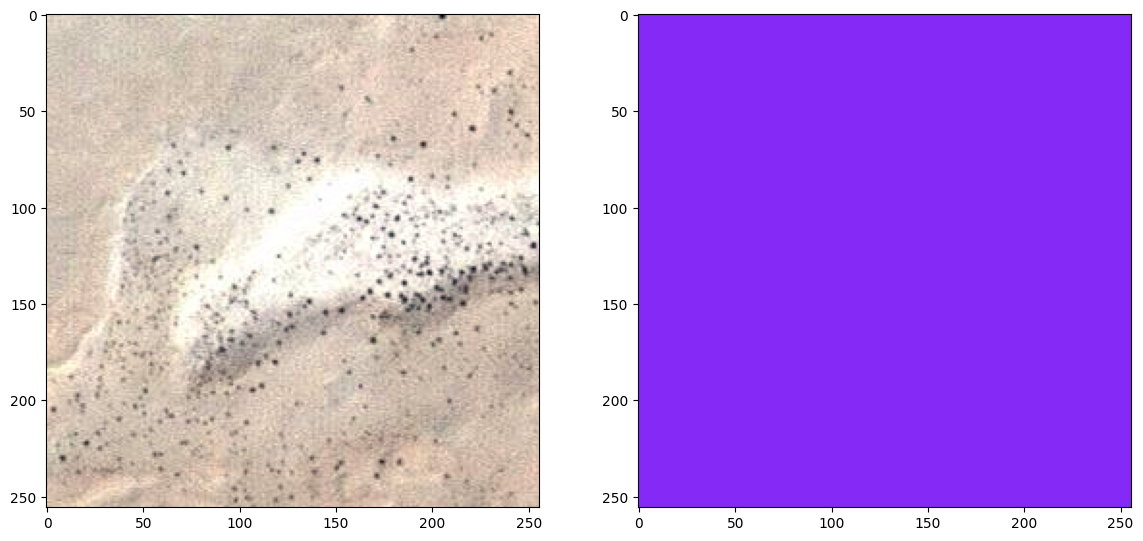

In [12]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

# Converting labels

In [13]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [14]:
label = individual_patched_mask

In [15]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [16]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [17]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [18]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [19]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


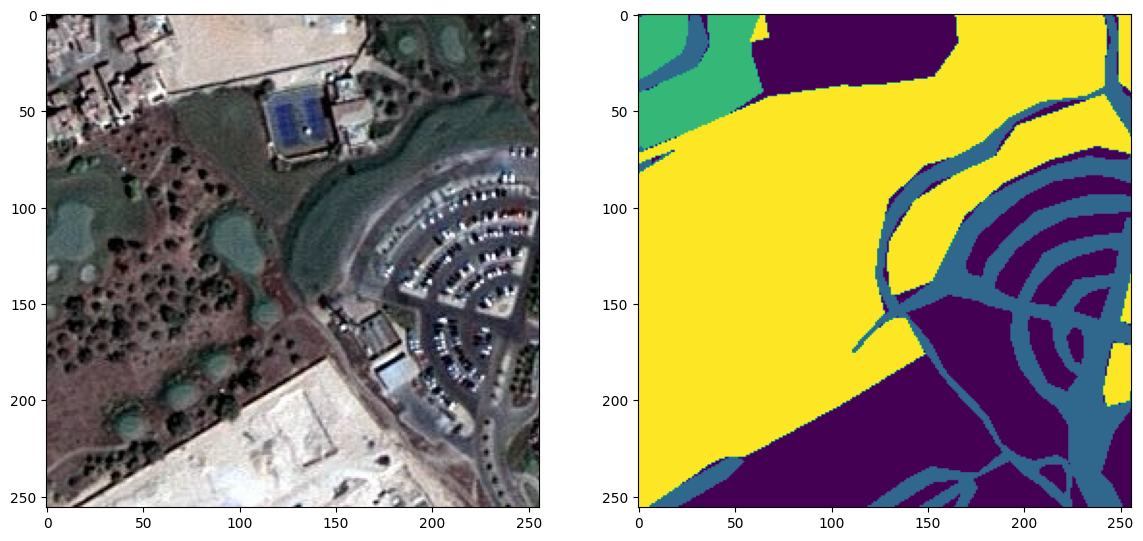

In [20]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [21]:
total_classes = len(np.unique(labels))

In [22]:
total_classes

6

In [23]:
from tensorflow.keras.utils import to_categorical

In [28]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [29]:
master_trianing_dataset = image_dataset

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [33]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [34]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# Jaccard and Dice Coeffcient

In [35]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [37]:
metrics = ["accuracy", jaccard_coef, dice_coef]

In [38]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [39]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [40]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [41]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [42]:
total_loss = dice_loss + (1 * focal_loss)

In [43]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=total_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss= total_loss, metrics=metrics)

print(model_resnet_backbone.summary())

85521592/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                           

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = 'Satelite_Segmentation-Resnet34.h5',
    save_best_only = True,
#     save_weights_only = False,
    monitor = 'val_loss',
    mode = 'auto',
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 12,
    mode = 'auto',
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training_2.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [45]:
history2 = model_resnet_backbone.fit(X_train_prepr,  # Training data
                                    y_train,          # Training labels
                                    batch_size=1,     # Batch size
                                    epochs=100,       # Number of training epochs
                                    verbose=1,        # Verbosity level (0 for silent, 1 for progress bar, 2 for one line per epoch)
                                    callbacks=callbacks,
                                    validation_data=(X_test_prepr, y_test))  # Validation data



Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
802/803 [============================>.] - ETA: 0s - loss: 1.0099 - accuracy: 0.5477 - jaccard_coef: 0.2175 - dice_coef: 0.3497
Epoch 1: val_loss improved from inf to 1.02862, saving model to Satelite_Segmentation-Resnet34.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


803/803 [==============================] - 127s 112ms/step - loss: 1.0098 - accuracy: 0.5480 - jaccard_coef: 0.2176 - dice_coef: 0.3499 - val_loss: 1.0286 - val_accuracy: 0.3105 - val_jaccard_coef: 0.1989 - val_dice_coef: 0.3225 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.623506263980886e-05.
Epoch 2/100
803/803 [==============================] - ETA: 0s - loss: 0.9951 - accuracy: 0.6223 - jaccard_coef: 0.2806 - dice_coef: 0.4303
Epoch 2: val_loss improved from 1.02862 to 0.98059, saving model to Satelite_Segmentation-Resnet34.h5
803/803 [==============================] - 84s 105ms/step - loss: 0.9951 - accuracy: 0.6223 - jaccard_coef: 0.2806 - dice_coef: 0.4303 - val_loss: 0.9806 - val_accuracy: 0.7343 - val_jaccard_coef: 0.4387 - val_dice_coef: 0.5859 - lr: 9.6235e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.261187281287936e-05.
Epoch 3/100
802/803 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.6830 - jaccard_

In [46]:
df_result = pd.DataFrame(history2.history)
df_result

,loss,accuracy,jaccard_coef,dice_coef,val_loss,val_accuracy,val_jaccard_coef,val_dice_coef,lr
0,1.009818,0.547995,0.217630,0.349909,1.028620,0.310494,0.198886,0.322544,0.000100
1,0.995130,0.622325,0.280604,0.430272,0.980585,0.734326,0.438685,0.585879,0.000096
2,0.987338,0.683266,0.323707,0.479865,0.977709,0.760154,0.506144,0.643655,0.000093
3,0.980542,0.732260,0.377155,0.536483,0.979286,0.745341,0.490496,0.630945,0.000089
4,0.975318,0.762983,0.426014,0.584843,0.978010,0.765740,0.503033,0.640547,0.000086
5,0.969918,0.795237,0.476308,0.631382,0.978662,0.776910,0.535873,0.669623,0.000083
6,0.964959,0.823302,0.525096,0.674163,0.980430,0.748032,0.486378,0.630010,0.000079
7,0.960475,0.844000,0.573668,0.713470,0.980437,0.769863,0.536943,0.672320,0.000076
8,0.957016,0.858847,0.615420,0.745795,0.985045,0.757608,0.547258,0.676724,0.000074
9,0.954163,0.876413,0.650790,0.773102,0.974974,0.791052,0.585519,0.714651,0.000071


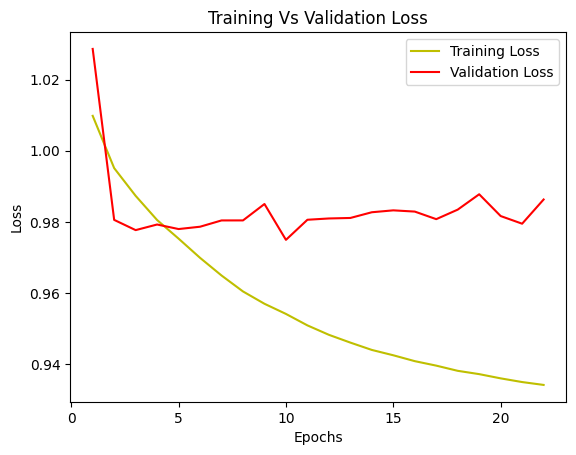

In [47]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

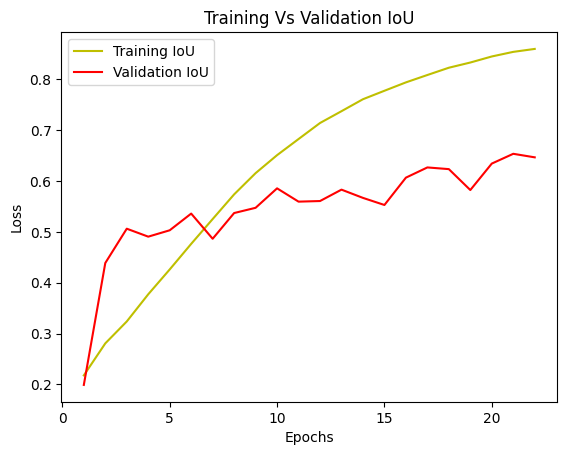

In [48]:
jaccard_coef = history2.history['jaccard_coef']
val_jaccard_coef = history2.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



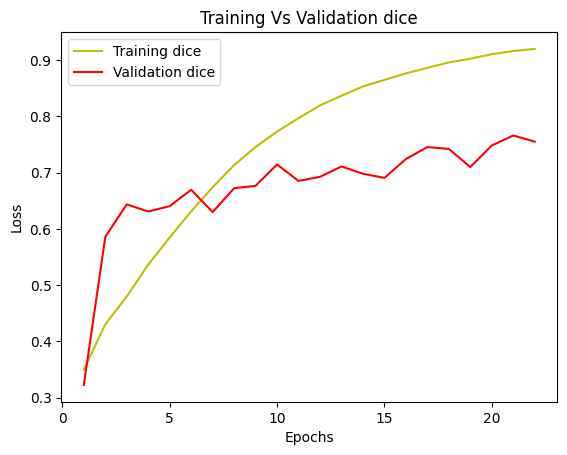

In [49]:
dice_coef = history2.history['dice_coef']
val_dice_coef = history2.history['val_dice_coef']

epochs = range(1, len(dice_coef) + 1)
plt.plot(epochs, dice_coef, 'y', label="Training dice")
plt.plot(epochs, val_dice_coef, 'r', label="Validation dice")
plt.title("Training Vs Validation dice")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [50]:
history2.params

{'verbose': 1, 'epochs': 100, 'steps': 803}

# Load Saved Model

In [51]:
from tensorflow.keras.models import load_model
# Load your trained model with the custom loss and metric functions
saved_model = load_model(
    "/content/Satelite_Segmentation-Resnet34.h5",
    custom_objects={
        'dice_loss_plus_1focal_loss': total_loss,
        'jaccard_coef': jaccard_coef,
        'dice_coef': dice_coef })

# Predicting test images along with ground truths

1/1 [==============================] - 0s 25ms/step


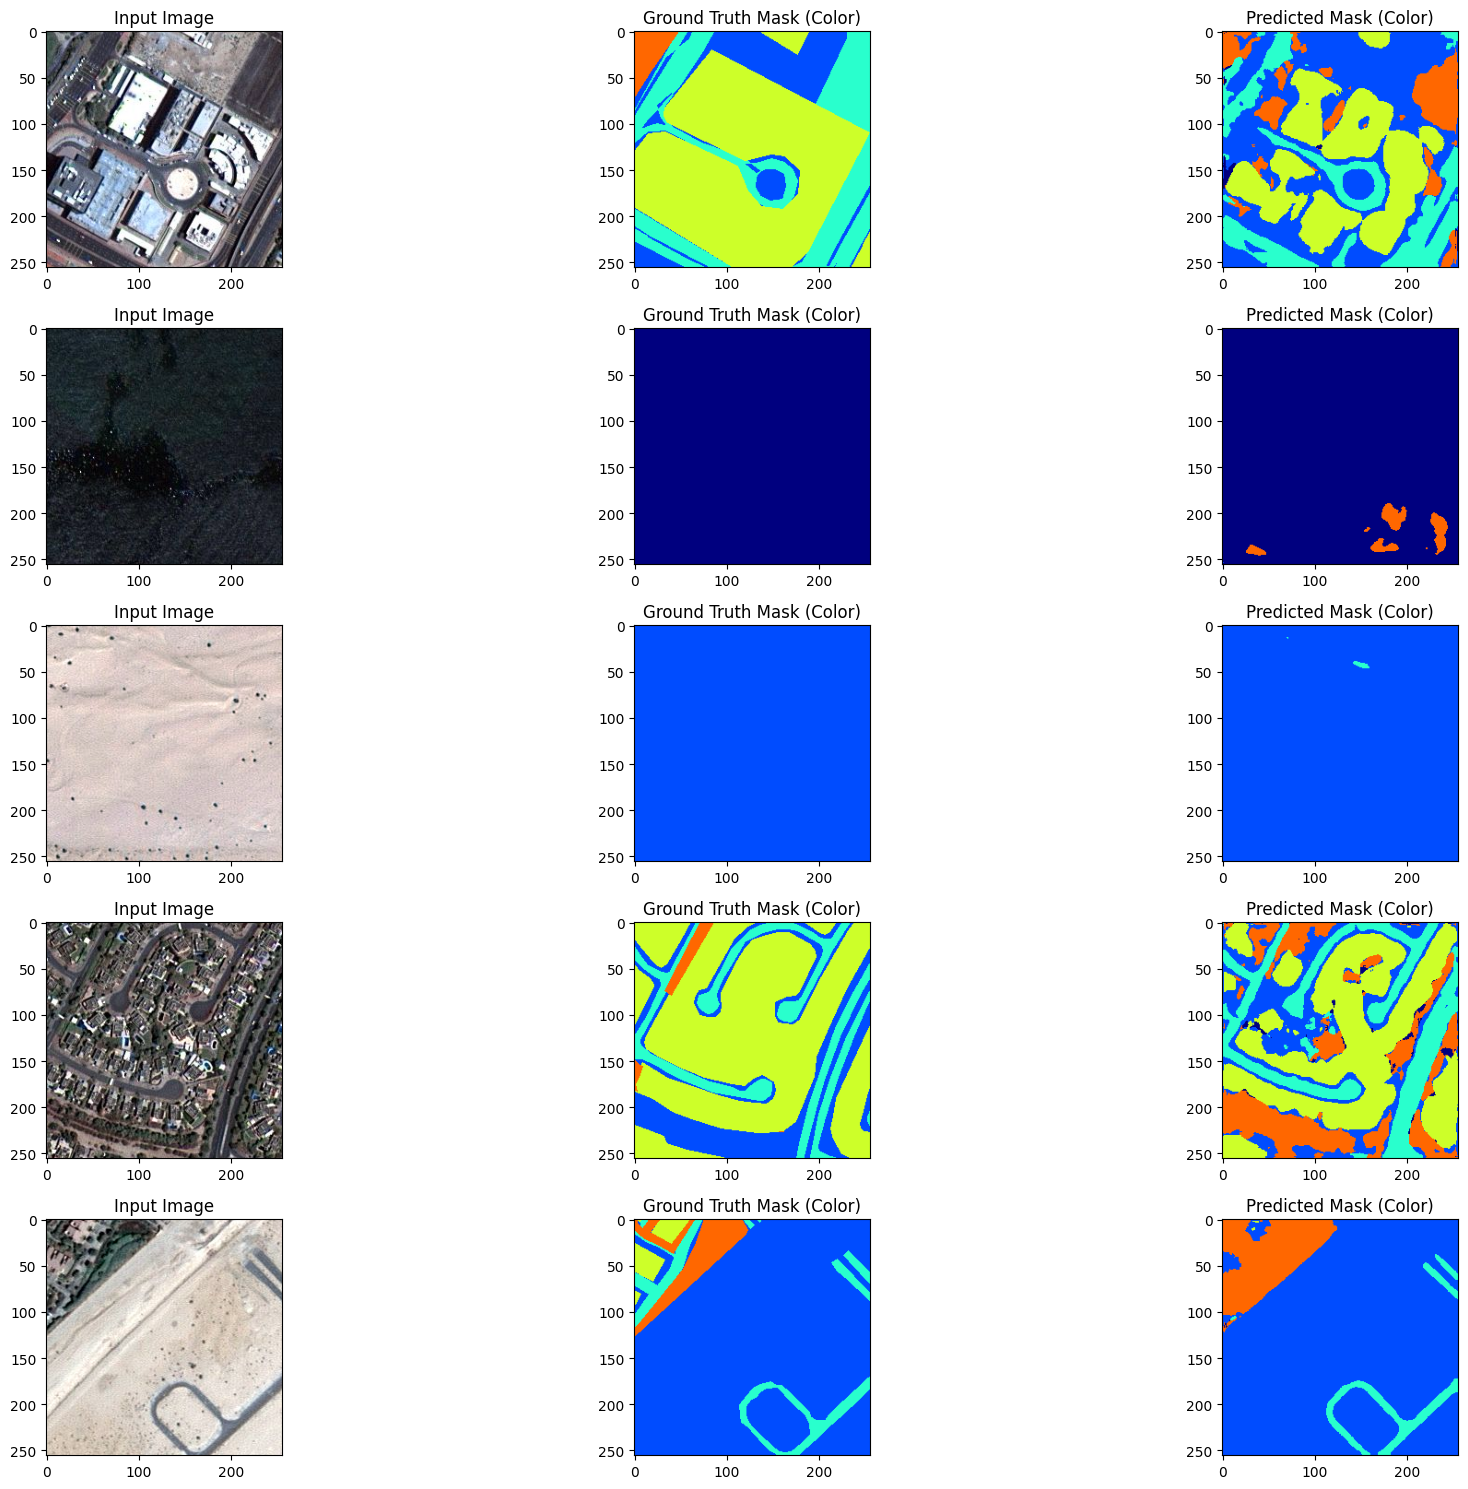

In [59]:
import matplotlib.cm as cm

# Define a color map for visualization
cmap = plt.get_cmap("jet")

# Select 5 random indices from X_test
num_samples = 5
random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)

# Increase the image size for visualization
fig, axes = plt.subplots(num_samples, 3, figsize=(20, 15))  # Adjust the figsize as needed

for i, idx in enumerate(random_indices):
    # Get the input image (1st column)
    input_image = X_test[idx]
    axes[i, 0].imshow(input_image)
    axes[i, 0].set_title("Input Image")

    # Get the ground truth mask (2nd column)
    ground_truth_mask = y_test[idx]  # Shape: (256, 256, 6)

    # Create a color mask by mapping values to colors using the color map
    color_mask = cmap(ground_truth_mask.argmax(axis=-1) / 5.0)  # Assuming there are 6 classes

    axes[i, 1].imshow(color_mask)
    axes[i, 1].set_title("Ground Truth Mask (Color)")

    # Make a prediction for the input image using the model (3rd column)
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
    predicted_mask = saved_model.predict(input_image)[0]  # Predict the mask

    # Create a color mask for the predicted mask
    color_predicted_mask = cmap(predicted_mask.argmax(axis=-1) / 5.0)  # Assuming there are 6 classes

    axes[i, 2].imshow(color_predicted_mask)
    axes[i, 2].set_title("Predicted Mask (Color)")

plt.tight_layout()
plt.show()

# Prediction for Random Satellite Images

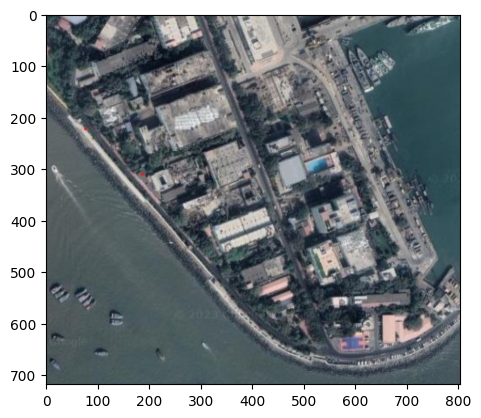

In [54]:
plt.imshow(Image.open("/content/sat_mumbai.jpg"))

In [55]:
#Resizing and converting into array
image=Image.open("/content/sat_mumbai.jpg")
image=image.resize((256,256))
image=np.array(image)
image=np.expand_dims(image,0)

In [56]:
prediction=saved_model.predict(image)

1/1 [==============================] - 1s 777ms/step


In [57]:
pred_image= np.argmax(prediction,axis=3)
pred_image=pred_image[0,:,:]

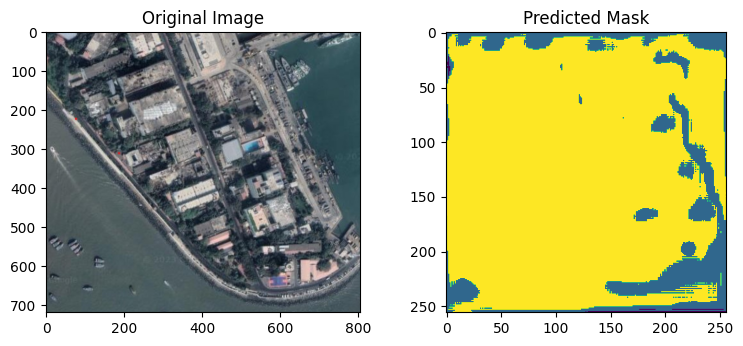

In [58]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open("/content/sat_mumbai.jpg"))
plt.subplot(232)
plt.title("Predicted Mask")
plt.imshow(pred_image)

In [ ]:
#https://netron.app/ to visualize final model

#Visualize Activation Outputs

In [ ]:
!pip install keract

In [ ]:
import keract as ke

In [ ]:
activations=ke.get_activations(saved_model, image, nodes_to_evaluate=None,output_format="simple",auto_compile=True )

In [ ]:
ls -lah /content/activations

In [ ]:
ke.display_activations(activations,cmap="viridis",save=True,directory="/content/activations")

In [ ]:
plt.imshow(Image.open('/content/activations/0_input_1.png'))

In [ ]:
plt.imshow(Image.open('/content/activations/1_conv2d.png'))

In [ ]:
plt.imshow(Image.open('/content/activations/40_conv2d_18.png'))